# <b style='color:green'>Employee Turnover EDA <b>

## <span style="color:#1789B6 ;">Introduction</span>

#### <b>Context:</b>
#### This EDA aims to explore a database provided by a large US company (no name given for privacy reasons). The management department is worried about the relatively high turnover. They want to find ways to reduce the number of employees leaving the company and to better understand the situation, which employees are more likely to leave, and why.

#### The HR department has assembled data on almost 10,000 employees who left the company between 2016-2020. They used information from exit interviews, performance reviews, and employee records.

### <b style='color:#DD702C ;'> Problem Statement:</b> <b>"How can the company reduce the monthly employee turnover by 20% within the next year through actionable insights derived from analyzing employee feedback, performance reviews, workload, and compensation?" </b>

---

## Part I: <span style="color:purple">EDA</span>

### <span style="color:#1789B6 ;">Configuration</span>

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy.stats import shapiro, skew, kurtosis
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
sns.set_style("darkgrid")

In [100]:
# Load the dataset
df = pd.read_csv(r"C:\Users\User\Jupyter Projects\capstone_II\employee_churn_data.csv")

In [3]:
pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\User\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: daal4py, imbalanced-learn, scikit-learn-intelex
Note: you may need to restart the kernel to use updated packages.


---

## <span style="color:#1789B6 ;">Data Preprocessing</span>

### Initial exploration

In [3]:
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [4]:
# Confirm no null values
df.sum().isnull()

department       False
promoted         False
review           False
projects         False
salary           False
tenure           False
satisfaction     False
bonus            False
avg_hrs_month    False
left             False
dtype: bool

In [22]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

print(f"Number of duplicate rows = {duplicate_rows.shape[0]}")

Number of duplicate rows = 0


---

## <span style="color:#1789B6 ;">Numerical Feature Exploration</span>

### Descriptive Stats Overview

In [101]:
# Select only numeric columns, exclude the binary columns 'promoted' and 'bonus', and display the top-level descriptive statistics.
df_numerical = df.select_dtypes(include=['int64', 'float64']).drop(columns=['promoted', 'bonus'])

df_numerical.describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.651826,3.274843,6.556184,0.504645,184.661571
std,0.085307,0.579136,1.415432,0.158555,4.144831
min,0.310000,2.000000,2.000000,0.000000,171.374060
25%,0.592884,3.000000,5.000000,0.386801,181.472085
50%,0.647456,3.000000,7.000000,0.500786,184.628796
75%,0.708379,4.000000,8.000000,0.622607,187.728708
max,1.000000,5.000000,12.000000,1.000000,200.861656


#### Based on the desriptive stats by numerical features, we could hypothesize that the most interesting values we should seek to explore involve the lower quartiles for satisfaction and reviews, as well as the upper quartiles for avg_hrs_month.
#### <b>Are the employees that work more than 187 hours a month likely to leave?
#### <b>Do employees that have low satisfaction and reviews scores stick around or exit the company? 

### Distribution Analysis

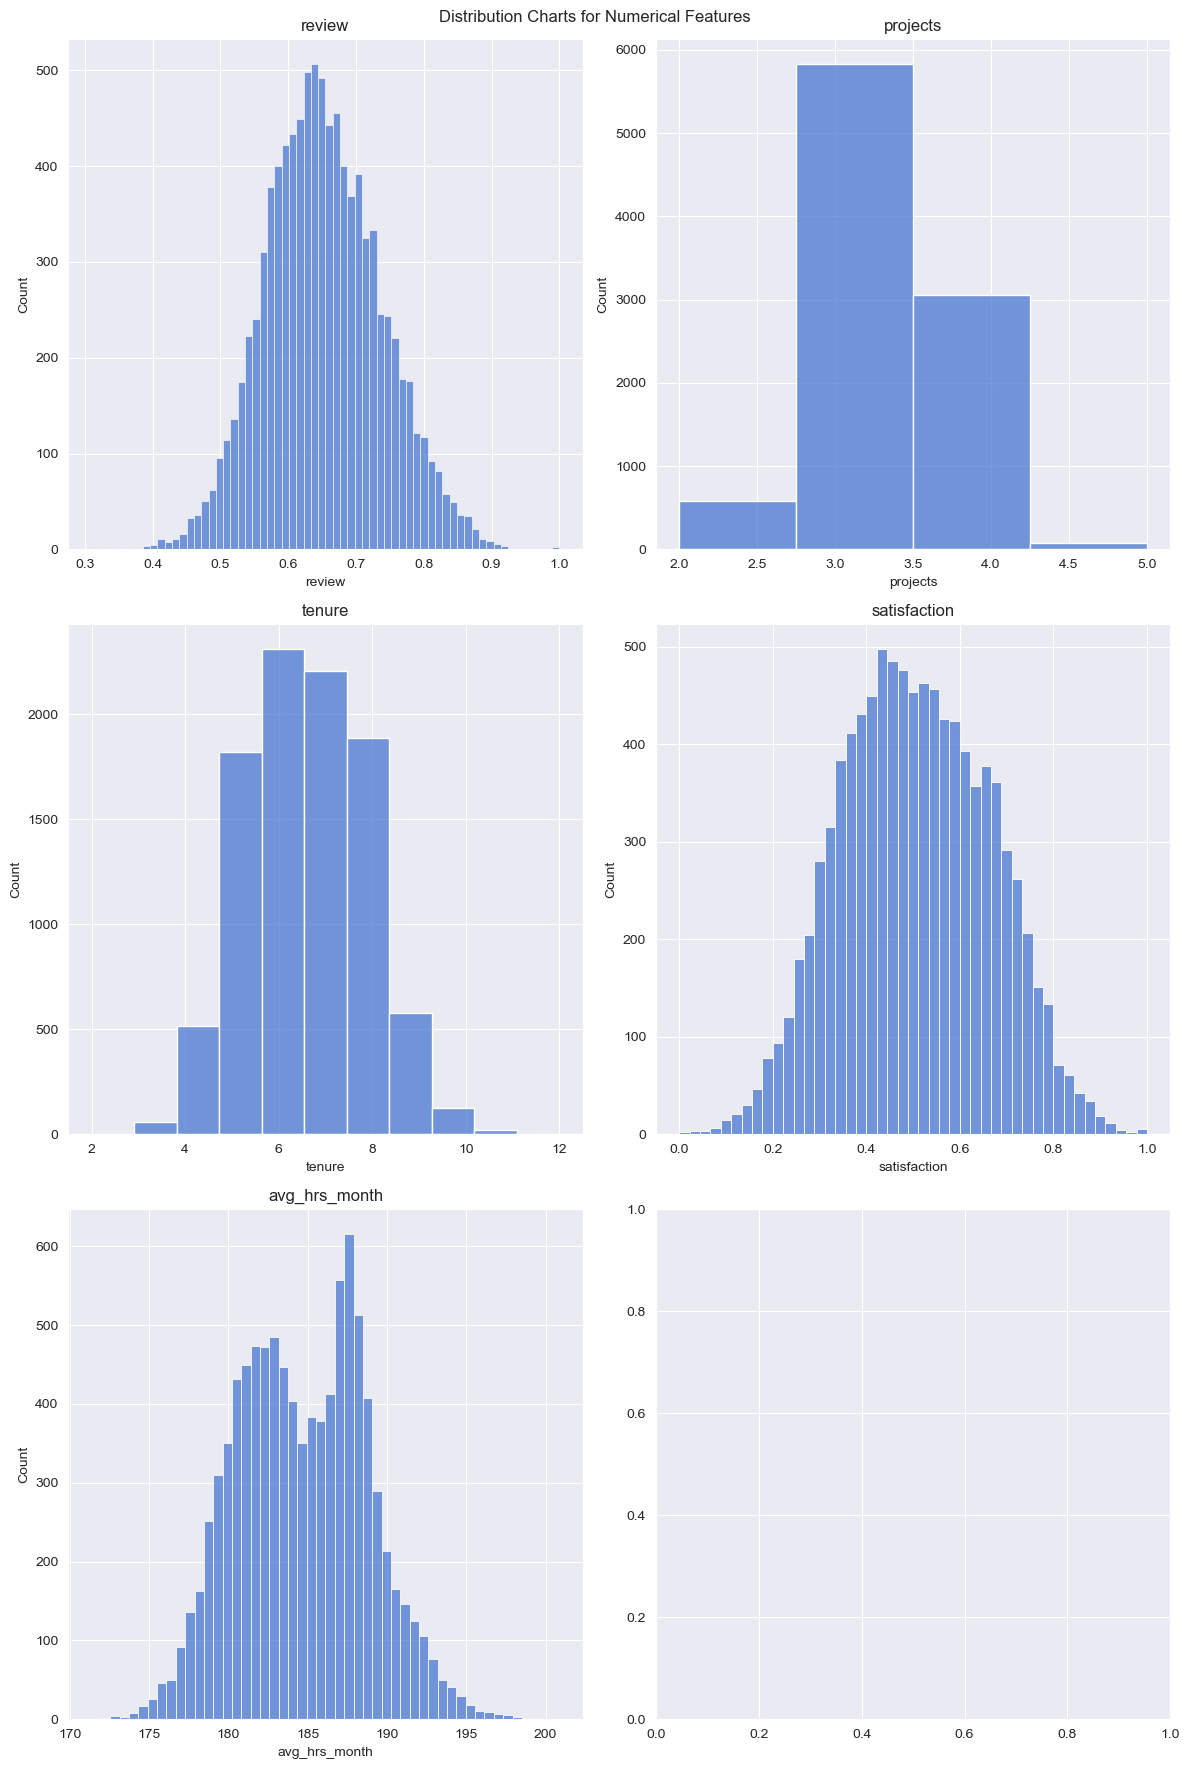

In [194]:
numerical_cols = df_numerical.columns

# Set up the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(12, 18)) 

# Plot the columns
for i, column in enumerate(numerical_cols):
    row = i // 2  # Integer division to get row index
    col = i % 2   # Remainder to get column index

    # If the current column is 'projects' or 'tenure', adjust the bin size
    if column in ['projects', 'tenure']:
        bins = df_numerical[column].nunique()
    else:
        bins = 'auto'
    
    sns.histplot(df_numerical[column], bins=bins, kde=False, ax=axs[row, col])
    axs[row, col].set_title(column)
   

fig.suptitle('Distribution Charts for Numerical Features')
plt.tight_layout()
plt.show()

#### The numerical features in the dataset, except for avg_hrs_month, appear to be Gaussian distributed. This will not effect the classification models that we will attempt to run to predict employee churn, however.
#### <b>What is the ratio of employee churn based on reviews less than the median review score?

In [179]:
# Calculate the median review value
median_review = df['review'].median()

# Create the Dataframes for employees below the median and above the median
low_reviews = df[df['review'] <= median_review]
high_reviews = df[df['review'] >= median_review]

# Calculate exit rate for each group
low_exit_rate = low_reviews['left_binary'].mean() * 100
high_exit_rate = high_reviews['left_binary'].mean() * 100

print(f"Exit rate for employees below the 50th percentile: {low_exit_rate:.2f}%")
print(f"Exit rate for all other employees: {high_exit_rate:.2f}%")

Exit rate for employees below the 50th percentile: 19.33%
Exit rate for all other employees: 39.04%


#### <b>The avg_hrs_month feature is bimodal normally distributed. There are clearly two clusters visible around the 180 and 188 hrs/month ticks. Are employees in the 188 hr cluster more likely to leave?</b>

In [180]:
# Calculate the 50th and 75th percentiles
p50 = df['avg_hrs_month'].quantile(0.5)
p75 = df['avg_hrs_month'].quantile(0.75)

# Create two dataframes: one for employees in the 50th to 75th percentile range, and another for the rest
mid_range_df = df[(df['avg_hrs_month'] >= p50) & (df['avg_hrs_month'] <= p75)]
other_df = df[(df['avg_hrs_month'] < p50) | (df['avg_hrs_month'] > p75)]

# Calculate the exit rate for each group
mid_range_exit_rate = mid_range_df['left_binary'].mean() * 100
other_exit_rate = other_df['left_binary'].mean() * 100

print(f"Exit rate for employees in the 50th to 75th percentile: {mid_range_exit_rate:.2f}%")
print(f"Exit rate for all other employees: {other_exit_rate:.2f}%")

Exit rate for employees in the 50th to 75th percentile: 39.96%
Exit rate for all other employees: 25.59%


### Exploration of Categorical Features

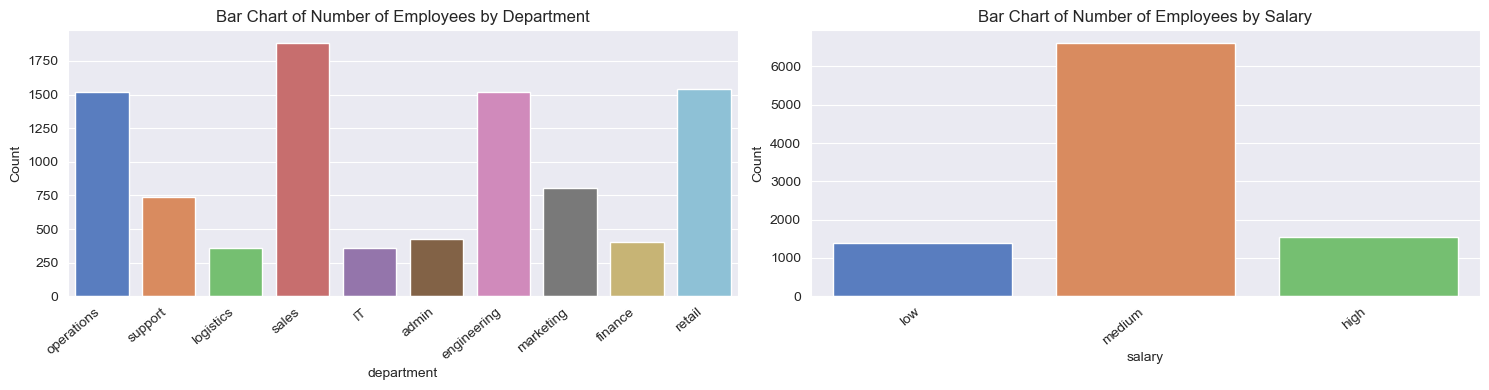

In [189]:
categorical = ['department', 'salary']

# Create a subplot environment
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.set_palette('muted')
# Iterate over the columns and plot them
for i, col in enumerate(categorical):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f"Bar Chart of Number of Employees by {str.capitalize(col)}")
    axs[i].set_ylabel('Count')
    # Rotate x-axis labels for better visibility
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

### Exploration of Employees Exited

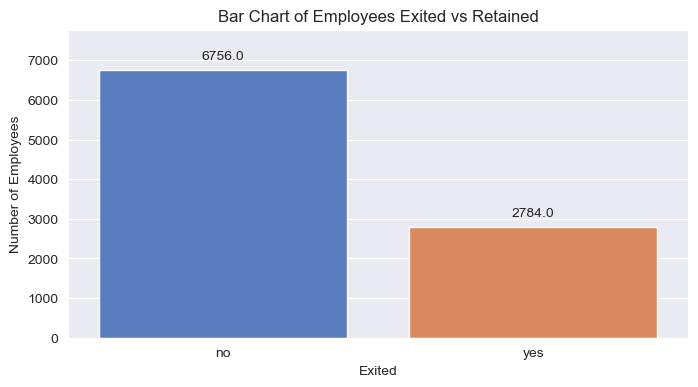

In [182]:
# Plot the distribution of exited employees
plt.figure(figsize=(8, 4))
sns.set_palette("muted")
ax = sns.countplot(x="left", data=df)

# Adding the title and axis labels
plt.title('Bar Chart of Employees Exited vs Retained')
plt.ylabel('Number of Employees')
plt.xlabel('Exited')
# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Formatting data label placement
max_count = df['left'].value_counts().max()
plt.ylim(0, max_count + 0.15 * max_count)
plt.show()

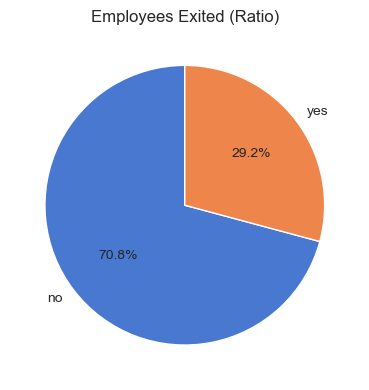

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the "muted" palette colors
muted_colors = sns.color_palette("muted")

# Get the number of unique values
num_unique_values = df['left'].nunique()

# Visualize as a ratio
plt.figure(figsize=(8,4))
df['left'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=muted_colors[:num_unique_values])
plt.title('Employees Exited (Ratio)')
plt.ylabel(None)
plt.tight_layout()
plt.show()

### Observing Outliers

#### Since the values differ greatly, we should visualize our boxplots seperately.

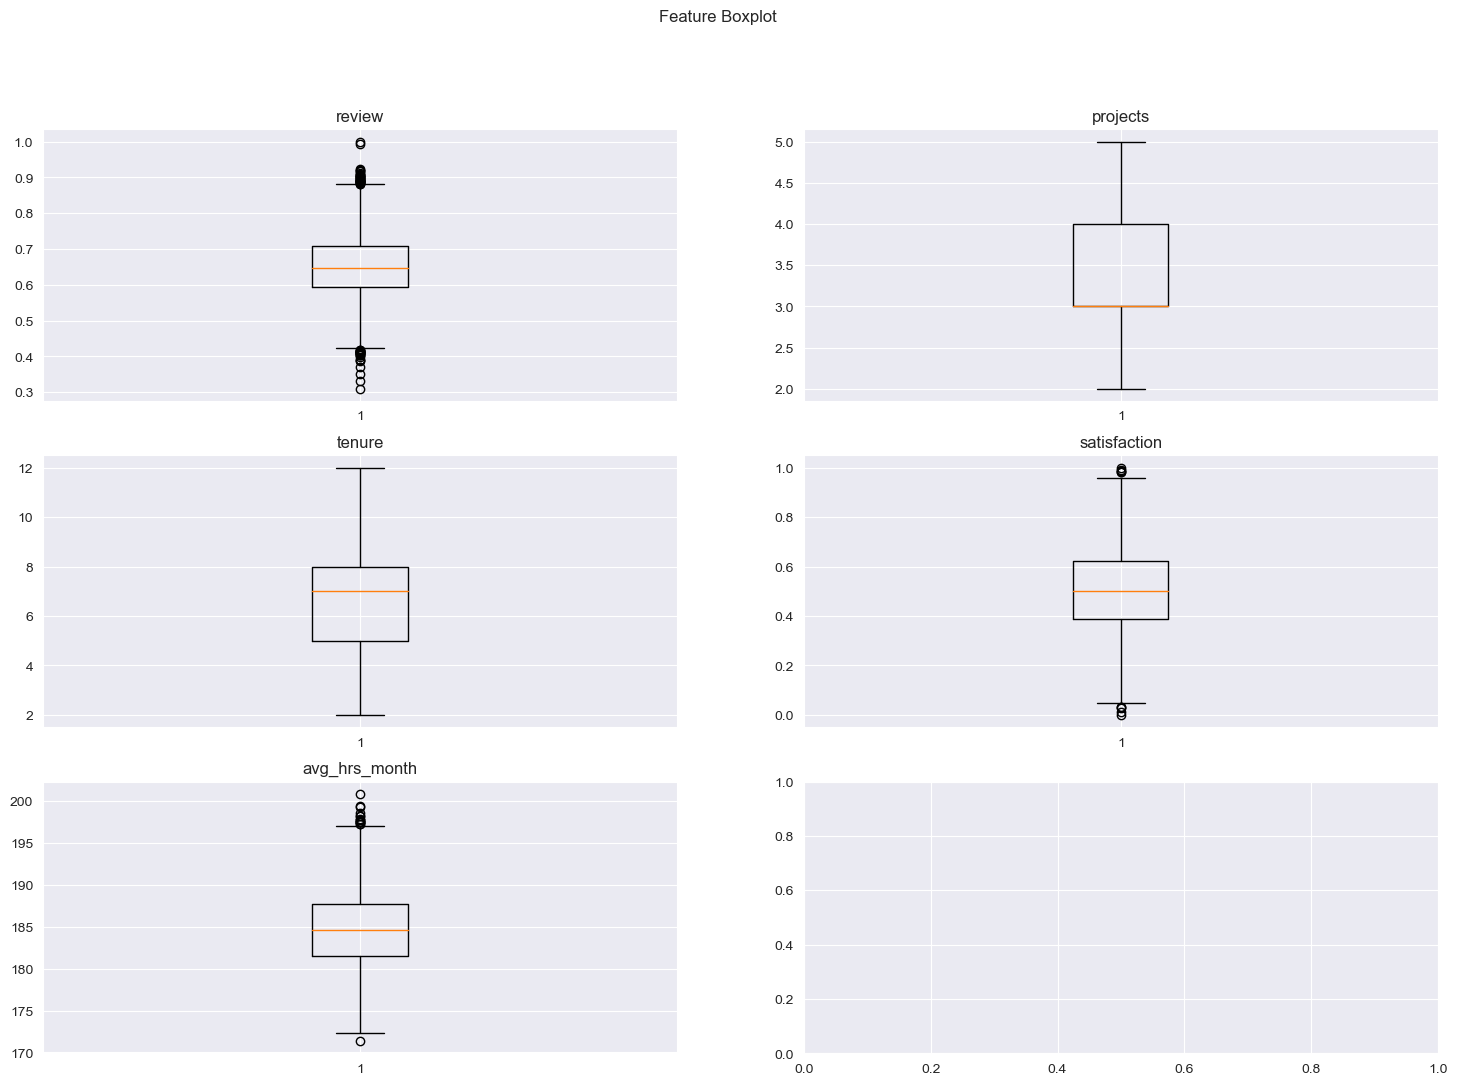

In [10]:
# Create a separate graph for each column's boxplot
columns = df_numerical.columns
n = len(df_numerical.columns)

# Set up the figure and axes
fig, axs = plt.subplots(3,2, figsize=(18, 12)) 

# Plot the columns
for i, column in enumerate(columns):
    row = i // 2  # Integer division to get row index
    col = i % 2   # Remainder to get column index
    axs[row, col].boxplot(df_numerical[column])
    axs[row, col].set_title(column)

fig.suptitle('Feature Boxplot')
plt.show()

#### It appears that there are some outliers in the <b> 'review', 'satisfaction'</b>, and <b>'avg_hrs_month'</b> columns.

#### Let's view the number of outliers as a % for the three columns of interest.

In [156]:
# Set columns of interest with outliers
outlier_columns = df[['review', 'satisfaction', 'avg_hrs_month']]

# Set the quartiles
Q1 = outlier_columns.quantile(.25, numeric_only=True)
Q3 = outlier_columns.quantile(.75, numeric_only=True)

In [157]:
print("Q1:", Q1, "\n", "Q3:", Q3)

Q1: review             0.592884
satisfaction       0.386801
avg_hrs_month    181.472085
Name: 0.25, dtype: float64 
 Q3: review             0.708379
satisfaction       0.622607
avg_hrs_month    187.728708
Name: 0.75, dtype: float64


In [158]:
# Set IQR
IQR = Q3 - Q1
IQR

review           0.115495
satisfaction     0.235806
avg_hrs_month    6.256624
dtype: float64

In [159]:
# Create lower and upper limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

In [160]:
# Align the DataFrame and Series objects
aligned_df, lower_limit = outlier_columns.align(lower_limit, axis=1, copy=False)
aligned_df, upper_limit = outlier_columns.align(upper_limit, axis=1, copy=False)

# Find the outliers
outliers_mask = ((aligned_df < lower_limit) | (aligned_df > upper_limit)).any(axis=1)
outliers = aligned_df[outliers_mask]

# Calculate percentage of outliers
percentage_outliers = str(round((len(outliers) / len(outlier_columns)) * 100, 2)) + "%"
print(f"{percentage_outliers} of the data consists of outliers")

0.85% of the data consists of outliers


#### We can observe that <b> < 1% </b> of the data <b> consists of outliers</b> for those columns. Given that the outliers are genuine and not made in error, we are not going to remove them from the dataset.
#### It may be useful to keep the outliers as these outlier values may explain some of the variance of the data as it relates to employee churn.

---

## <span style="color:#1789B6 ;">Categorical Correlations</span>

### Exited by Salary

In [195]:
contingency_table = pd.crosstab(df['salary'], df['left'])
print(contingency_table)

left      no   yes
salary            
high    1106   442
low      990   391
medium  4660  1951


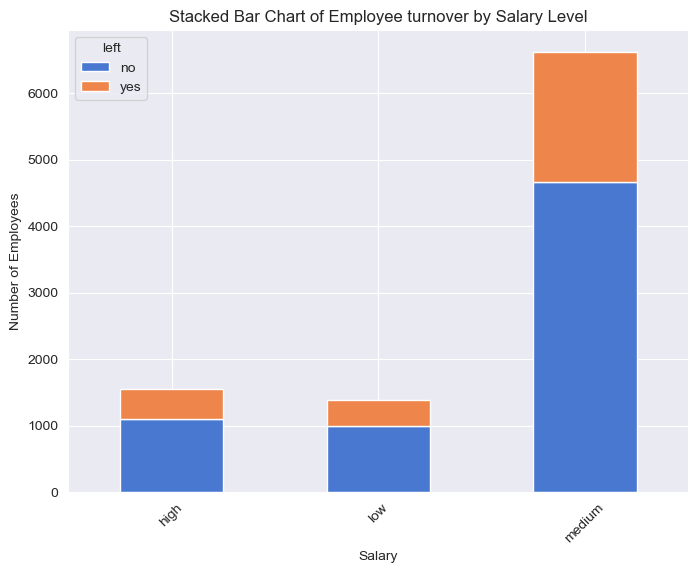

In [200]:
contingency_table.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title("Stacked Bar Chart of Employee turnover by Salary Level")
plt.ylabel("Number of Employees")
plt.xlabel('Salary')
plt.xticks(rotation=45)
plt.show()

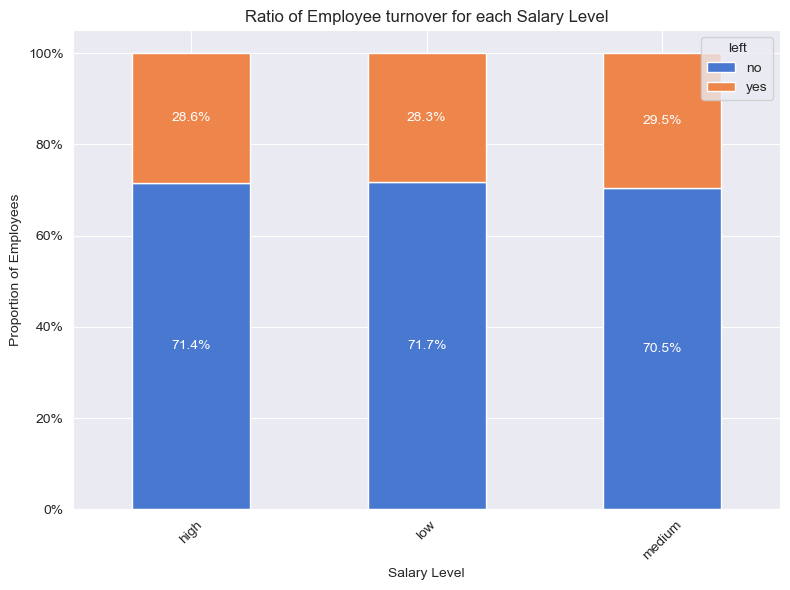

In [153]:
# Normalize the crosstab table across rows to get the proportion
normalized_contingency = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plot
ax = normalized_contingency.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title("Ratio of Employee turnover for each Salary Level")
plt.ylabel("Proportion of Employees")
plt.xlabel("Salary Level")

from matplotlib.ticker import PercentFormatter
# Adjust y-axis to show percentages
ax.yaxis.set_major_formatter(PercentFormatter(1))

# Add percentage data labels above each segment
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the percentage
    percentage = f'{height*100:.1f}%'
    
    # Place text at the end of the rectangle
    ax.text(x + width/2., y + height/2., percentage, ha="center", va="center", color="white", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Interestingly enough, it appears that salary does not explain the variance for employee churn in this dataset. This is suprising, given that intuitely, employees would be more likely to churn if they feel inadequately compensated.

### Exited by Department

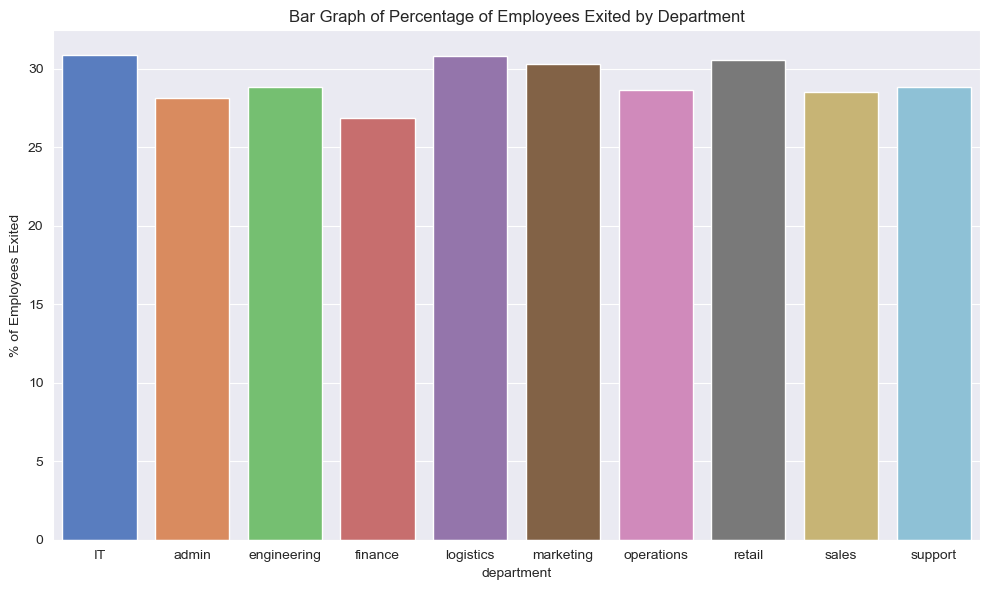

In [151]:
# Sort by department and exited, then pivot around the exited column
department_left_counts = df.groupby(['department', 'left_binary']).size().unstack()

# Show the exited by department value as a %
department_left_counts['left_percentage'] = department_left_counts[1] / (department_left_counts[0] + department_left_counts[1]) * 100
plt.figure(figsize = (10,6))
sns.barplot(x = department_left_counts.index, y = department_left_counts['left_percentage'], palette = 'muted')
plt.title('Bar Graph of Percentage of Employees Exited by Department')
plt.ylabel('% of Employees Exited')
plt.tight_layout()
plt.show()

In [148]:
# Find the average % of exited employees by department
round(department_left_counts['left_percentage'].mean(),2)

29.24

#### It appears that the distribution of exited employees across departments is not highly indicative of employee churn, either.
#### On average, across all departments, 29.2% of employees have exited the company.

---

## <span style="color:#1789B6 ;">Inferential Statistics</span>

### Correlation Matrix for Numerical Features

In [126]:
# Convert the 'left' category to binary
binary_map = {'yes': 1, 'no': 0 }
df['left_binary'] = df['left'].map(binary_map)

In [127]:
df['left_binary']

0       0
1       0
2       0
3       0
4       0
       ..
9535    1
9536    1
9537    1
9538    1
9539    1
Name: left_binary, Length: 9540, dtype: int64

In [108]:
corr_matrix = df.corr( numeric_only=True)

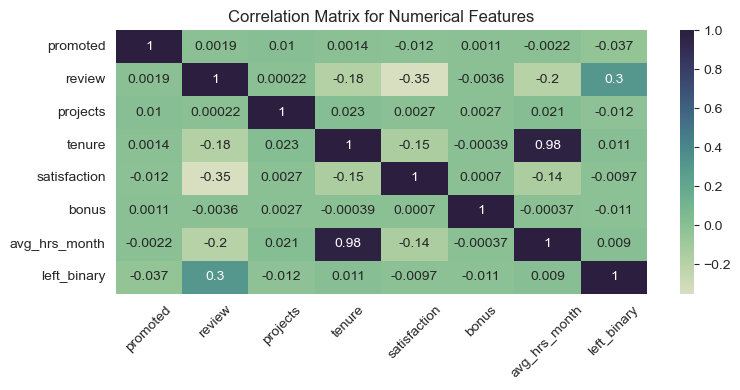

In [109]:
# Plot the correlation matrix
plt.figure(figsize=(8,4))
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap = cmap)
plt.xticks(rotation=45)
plt.title('Correlation Matrix for Numerical Features')
plt.tight_layout()
plt.show()

In [110]:
sorted_corr = corr_matrix['left_binary'].sort_values(ascending = False)
type(sorted_corr)

pandas.core.series.Series

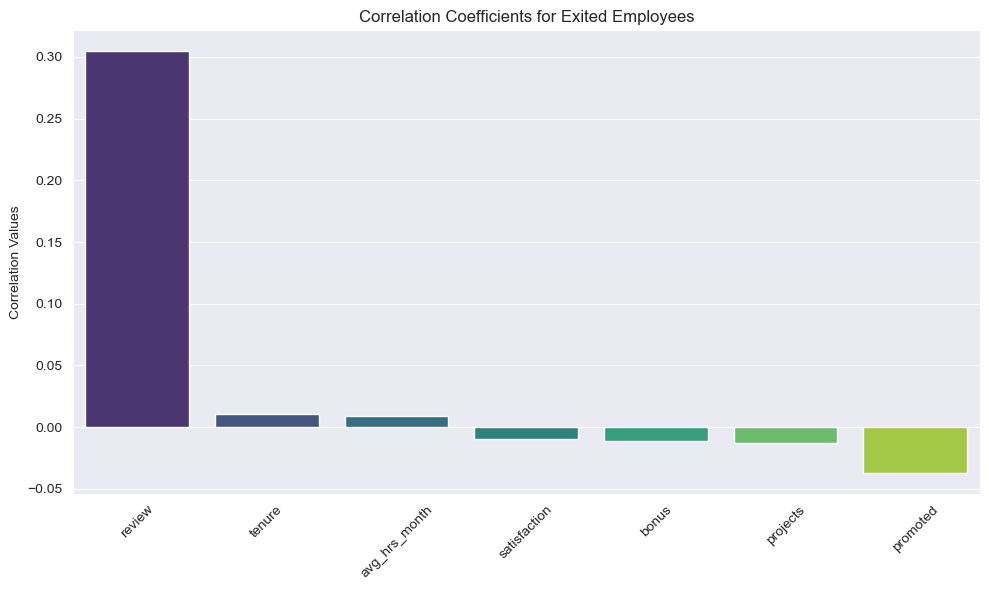

In [140]:
# Visualize the sorted correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_corr.drop('left_binary').index, y=sorted_corr.drop('left_binary').values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Correlation Values')
plt.title('Correlation Coefficients for Exited Employees')
plt.tight_layout()
plt.show()

#### It appears that the feature with the highest correlation to exiting the company is 'review', although none of the features are particularly compelling in terms of positive or negative correlation strength. 
#### This suggests that these features may exhibit a non-linear relationship with exiting the company. 

---

## Part II: <span style="color:purple">Modeling</span>

#### Our goal now is to find a model that is relatively successful for predicting employee churn. Once the categorical features are tansformed into numerical and the dataset is standardized, we will start by applying a logistic regression model. 
#### Depending on the model's performance, we may need to fine-tune hyperparameters and retest, or compare it to the test performance of other models.

## <span style="color:#1789B6 ;">Logistic Regression</span>

### One-hot Encoding for 'Salary' and 'Department' Features

In [105]:
from sklearn.preprocessing import OneHotEncoder

# 1. Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# 2. Fit and Transform
encoded_features = encoder.fit_transform(df[['department', 'salary']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['department', 'salary']))

# 3. Merge Encoded Dataframe with Original
df_encoded = pd.concat([df, encoded_df], axis=1)

# Drop the original 'department' and 'salary' columns
df_encoded.drop(['department', 'salary'], axis=1, inplace=True)

In [134]:
# Now, df_encoded is the dataframe with the one-hot encoded features
df_encoded

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,left,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support,salary_low,salary_medium
0,0,0.577569,3,5.0,0.626759,0,180.866070,no,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0.751900,3,6.0,0.443679,0,182.708149,no,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0.722548,3,6.0,0.446823,0,184.416084,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,0.675158,4,8.0,0.440139,0,188.707545,no,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.676203,3,5.0,0.577607,1,179.821083,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9535,0,0.610988,4,8.0,0.543641,0,188.155738,yes,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9536,0,0.746887,3,8.0,0.549048,0,188.176164,yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9537,0,0.557980,3,7.0,0.705425,0,186.531008,yes,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9538,0,0.584446,4,8.0,0.607287,1,187.641370,yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Splitting Test and Training Data

In [131]:
# Split the test and train data and validate the split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, stratify = Y, random_state = 2)

In [132]:
# Separate the target variable 
Y = df['left_binary']

In [135]:
# Set the features equal to the new df without the target variable
X = df_encoded.drop(['left'], axis = 1)

### Standardize the new DataFrame

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply SMOTE to Address Employee Churn Imbalance

In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2)
X_train_smote, Y_train_smote = smote.fit_resample(X_train_scaled, Y_train)

### Model Training

In [55]:
model = LogisticRegression(random_state=2, solver='saga', max_iter=5000, C=0.5)
model.fit(X_train, Y_train)

LogisticRegression(C=0.5, max_iter=5000, random_state=2, solver='saga')

### Model Evaluation

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Y_pred = model.predict(X_test_scaled)

# Classification report
print(classification_report(Y_test, Y_pred))

# Confusion matrix
print(confusion_matrix(Y_test, Y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred))


              precision    recall  f1-score   support

           0       0.82      0.60      0.69      1689
           1       0.41      0.68      0.51       696

    accuracy                           0.62      2385
   macro avg       0.62      0.64      0.60      2385
weighted avg       0.70      0.62      0.64      2385

[[1012  677]
 [ 220  476]]
ROC AUC Score: 0.641539576570507


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Our model has a decent accuracy score, however the other metrics suggest that the model could use some work to increase its reliability for predicting whether an employee will exit or not.
#### We should experiment with hyperparameter tuning to see if we can improve the model's performance.

In [57]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

# Instantiate the GridSearchCV object with increased max_iter and tol
grid_search = GridSearchCV(LogisticRegression(tol=1e-4, max_iter=5000, random_state=2), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, Y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train a new model with the best parameters
best_model = LogisticRegression(**best_params, max_iter=5000, tol=1e-4, random_state=2)
best_model.fit(X_train_scaled, Y_train)


LogisticRegression(C=1, max_iter=5000, penalty='l1', random_state=2,
                   solver='saga')

In [58]:
# 1. Scale the test data
X_test_scaled = scaler.transform(X_test)

# 2. Predict using best_model
Y_pred_best = best_model.predict(X_test_scaled)

# 3. Print the metrics
# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_best))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_best))

# ROC AUC Score
print("\nROC AUC Score:", roc_auc_score(Y_test, Y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      1689
           1       0.56      0.24      0.34       696

    accuracy                           0.72      2385
   macro avg       0.65      0.58      0.58      2385
weighted avg       0.69      0.72      0.68      2385


Confusion Matrix:
[[1555  134]
 [ 526  170]]

ROC AUC Score: 0.5824579939160083


#### After attempting hyperparameter tuning, the model's performance was still lacking. The model performs best at correctly identifying employees who do not exit (with a precision of 0.75 and recall of 0.92) , however performs poorly at recognizing when an employee has exited (with a precision of 0.56 and a recall of 0.24).
#### Let's compare this Logistic Regression model's performance to a Random Forest Model.

---

## <span style="color:#1789B6 ;">Random Forest</span>

### Model Training

In [138]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=2)

# Train the model
rf_model.fit(X_train_smote, Y_train_smote)

RandomForestClassifier(random_state=2)

### Model Evaluation

In [139]:
# Predict using the Random Forest model
Y_rf_pred = rf_model.predict(X_test_scaled)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(Y_test, Y_rf_pred))

# Confusion matrix
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(Y_test, Y_rf_pred))

# ROC AUC Score
print("\nRandom Forest ROC AUC Score:", roc_auc_score(Y_test, Y_rf_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1689
           1       0.74      0.74      0.74       696

    accuracy                           0.85      2385
   macro avg       0.82      0.82      0.82      2385
weighted avg       0.85      0.85      0.85      2385


Random Forest Confusion Matrix:
[[1508  181]
 [ 181  515]]

Random Forest ROC AUC Score: 0.8163892631836834


#### The Random Forest model outperformed the Logistic Regression model in terms of accuracy and balance between precicion and recall for both classes. 
#### Let's see if we can continue to improve the performance of the model via hyperparameter tuning.

### Hyperparameter Tuning

In [62]:
from sklearn.model_selection import GridSearchCV

# Set parameter grid for searching for best params
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [136]:
# Conclude the best parameters from the grid search
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

In [137]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


### Model Retraining

In [89]:
# Retest the model
Y_train_pred = best_rf_model.predict(X_train_smote)
print("Training Classification Report:")
print(classification_report(Y_train_smote, Y_train_pred))
print("\nRandom Forest ROC AUC Score:", roc_auc_score(Y_train_smote, Y_train_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5067
           1       0.96      0.98      0.97      5067

    accuracy                           0.97     10134
   macro avg       0.97      0.97      0.97     10134
weighted avg       0.97      0.97      0.97     10134


Random Forest ROC AUC Score: 0.9724689165186501


In [78]:
Y_test_pred = best_rf_model.predict(X_test_scaled)
print("Test Classification Report:")
print(classification_report(Y_test, Y_test_pred))
print("\nRandom Forest ROC AUC Score:", roc_auc_score(Y_test, Y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1689
           1       0.73      0.75      0.74       696

    accuracy                           0.85      2385
   macro avg       0.81      0.82      0.82      2385
weighted avg       0.85      0.85      0.85      2385


Random Forest ROC AUC Score: 0.8180353096098487


In [70]:
param_grid = {
    'n_estimators': [50, 100, 200],  # added 50 to explore a smaller forest
    'max_depth': [5, 10, 20, None],  # added 5 to explore shallower trees
    'min_samples_split': [5, 10, 15],  # increased the range
    'min_samples_leaf': [2, 4, 6],  # increased the range
    'max_features': ['sqrt', 'log2', None],  # added this parameter
    'max_samples': [0.7, 0.8, 0.9, None]  # added this parameter
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.7, 0.8, 0.9, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [71]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

In [72]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


#### Some of these parameters were at the edge of the parameter grid, therefore we should retune the parameters to be closer to the best param values.

In [90]:
# Further tune the hyperparameters based on new best params
param_grid = {
    'n_estimators': [175, 200],  # kept best param range
    'max_depth': [18, 20, 22],  # added 5 to explore shallower trees
    'min_samples_split': [3, 5, 7],  # decreased the range closer to best
    'min_samples_leaf': [2, 3],  # decreased the range closer to best
    'max_features': ['sqrt'], # kept best param
    'max_samples': [None] # kept best param
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'max_depth': [18, 20, 22], 'max_features': ['sqrt'],
                         'max_samples': [None], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [175, 200]},
             scoring='accuracy')

In [87]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


In [84]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

In [85]:
Y_train_pred = best_rf_model.predict(X_train_smote)
print("Training Classification Report:")
print(classification_report(Y_train_smote, Y_train_pred))
print("\nRandom Forest ROC AUC Score:", roc_auc_score(Y_train_smote, Y_train_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5067
           1       0.96      0.98      0.97      5067

    accuracy                           0.97     10134
   macro avg       0.97      0.97      0.97     10134
weighted avg       0.97      0.97      0.97     10134


Random Forest ROC AUC Score: 0.9724689165186501


In [86]:
Y_test_pred = best_rf_model.predict(X_test_scaled)
print("Test Classification Report:")
print(classification_report(Y_test, Y_test_pred))
print("\nRandom Forest ROC AUC Score:", roc_auc_score(Y_test, Y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1689
           1       0.74      0.76      0.75       696

    accuracy                           0.85      2385
   macro avg       0.82      0.82      0.82      2385
weighted avg       0.85      0.85      0.85      2385


Random Forest ROC AUC Score: 0.8229377207488617


#### Our model exhibitted slight improvement with the parameter grid tuning. For the purposes of this project, we will use the results from the Random Forest for our final predictive model selection.
#### Let's check how the model weights importance of the features tested.

### Feature Importance

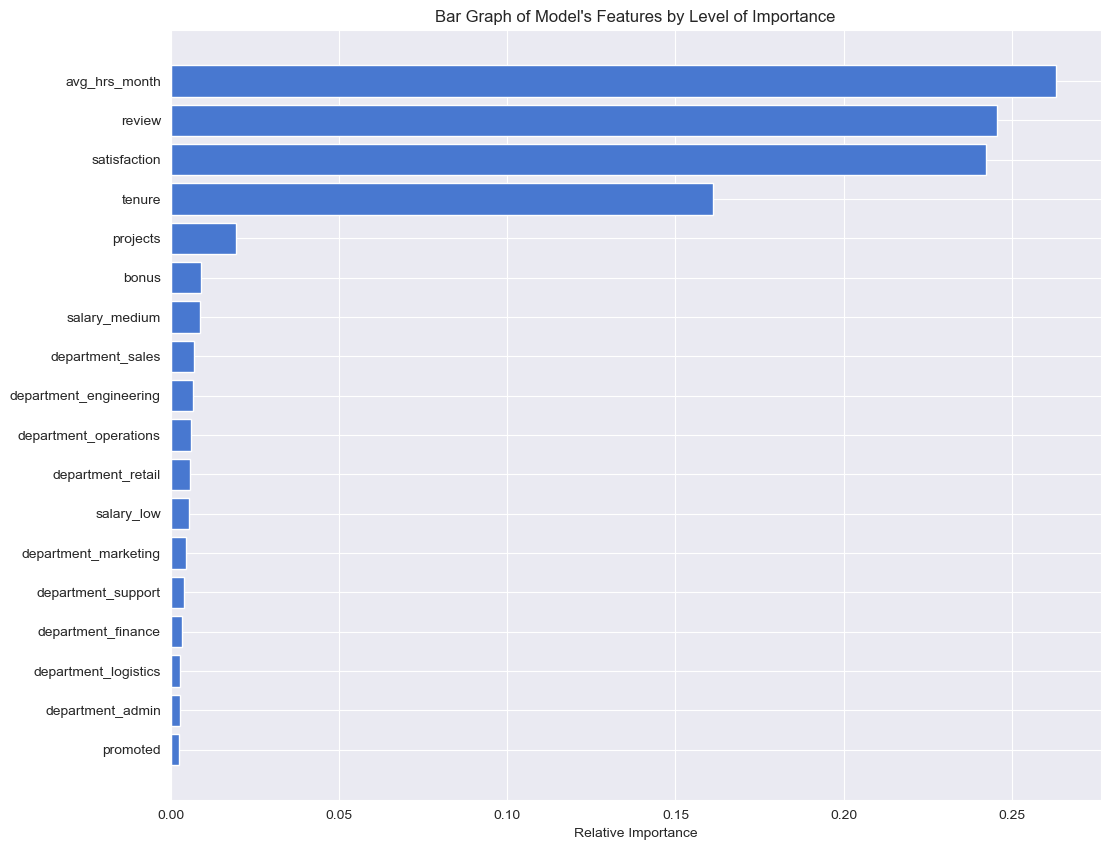

In [124]:
importances = best_rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 10))
plt.title("Bar Graph of Model's Features by Level of Importance")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


---

## <span style="color:#1789B6 ;">Insights</span>

### EDA Recap:

#### After observing numerical and categorical relationships to employee churn, we can report on a few key takeaways:

#### - ~30% of employees in this dataset have exited the company
#### - 40% of employees exited work between 184.6(50th percentile) and 187.7(75th percentile) hours
#### - Regardless of salary level (low, medium, and high), ~30% of employees have exited for each salary level
#### - On average, across all departments, 29.2% of employees have exited the company.
#### - Reviews seem to have the highset statistical correlation to employee churn, however the correlation value is only .3 indicating a relatively weak positive correlation

---

## <span style="color:#1789B6 ;">Results and Interpretation</span>

### Modeling

#### From our earlier analysis, it was clear that there wasn't a linear association between any of the features and the target variable "left." We also didn't engage in feature engineering, which might have unveiled more nuanced relationships related to employee churn. Given these factors, we anticipated that the Logistic Regression model might not deliver optimal results in terms of accuracy, precision, and recall. The following classification report confirms these expectations:
<b> Logistic Regression Test Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.92      0.82      1689
           1       0.56      0.24      0.34       696

    accuracy                           0.72      2385
   macro avg       0.65      0.58      0.58      2385

weighted avg       0.69      0.72      0.68      2385 

ROC AUC Score: 0.5824579939160083
#### As suspected, the Random Forest model performed much more desirabely, with prediciting accuracy at 82% after hyperparameter tuning. Below is the classification report indicating improvement in reducing type I and type II errors:
<b> Random Forest Test Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1689
           1       0.74      0.76      0.75       696

    accuracy                           0.85      2385
   macro avg       0.82      0.82      0.82      2385

weighted avg       0.85      0.85      0.85      2385


Random Forest ROC 
AUC Score: 0.8229377207488617

---

## <span style="color:#1789B6 ;">Recommendations</span>

#### <b>Work Hours Investigation:</b> Dive deeper into the work patterns of employees, especially those in the 50th to 75th percentile range of hours worked. Understand if they are facing burnout, unmanageable workloads, or other work-life balance issues.

#### <b>Holistic Retention Strategies:</b> Since salary doesn't appear to be a major factor in churn, focus on other aspects of employee satisfaction such as career progression, work environment, recognition, and benefits.

#### <b>Regular Employee Feedback:</b> The weak correlation between reviews and churn indicates that regular feedback sessions and surveys can be beneficial. By keeping a pulse on employee sentiments, preemptive actions can be taken before an employee decides to leave.

#### <b>Model Utilization:</b> Leverage the Random Forest model to predict potential churn and identify key features influencing these predictions. This can provide insights for targeted retention strategies.

#### <b>Targeted Departmental Strategies:</b> Even though the average churn across departments is consistent, individual department heads should be made aware of the numbers, prompting them to look into department-specific issues.

#### <b>Continuous Model Evaluation:</b> Regularly update and evaluate the model to ensure its relevance, especially as new data becomes available and company dynamics change.

---

### <b> Data Source </b>: https://www.kaggle.com/datasets/marikastewart/employee-turnover